In [1]:
from matplotlib import rcParams
import matplotlib.pyplot as plt
import numpy as np
import warnings
import pandas as pd
import xarray as xr
import string
from glob import glob
import re
import cartopy.crs as ccrs
from matplotlib_scalebar.scalebar import ScaleBar
from ast import literal_eval
import contextily as cx
from matplotlib.colors import ListedColormap
import geopandas as gpd
from shapely.geometry.point import Point
from pyproj.database import query_utm_crs_info
from pyproj import CRS
from pyproj.aoi import AreaOfInterest
import itertools


In [2]:

warnings.filterwarnings('ignore')

font_size = 17
rcParams['axes.titlesize'] = font_size
rcParams['axes.titleweight'] = 'bold'
rcParams['axes.labelsize'] = font_size - 2
rcParams['xtick.labelsize'] = font_size - 2
rcParams['ytick.labelsize'] = font_size - 2
rcParams['legend.fontsize'] = font_size
rcParams['figure.titlesize'] = font_size
rcParams['figure.titleweight'] = 'bold'

## Read plume nc and csv files

In [3]:
oil_list = sorted(glob('../data/ch4_cases/sectors/oil_gas/*plume*nc'))
# remove csf nc filenames from list
ds_oils = [xr.open_dataset(file) for file in oil_list if re.search(r'_plume\d+\.nc$', file)]
df_oils = [pd.read_csv(file.replace('.nc', '.csv'), converters={'plume_bounds': literal_eval}) for file in oil_list if re.search(r'_plume\d+\.nc$', file)]

In [4]:
coal_list = sorted(glob('../data/ch4_cases/sectors/coal_mining/*plume*nc'))
# remove csf nc filenames from list
ds_coals = [xr.open_dataset(file) for file in coal_list if re.search(r'_plume\d+\.nc$', file)]
df_coals = [pd.read_csv(file.replace('.nc', '.csv'), converters={'plume_bounds': literal_eval}) for file in coal_list if re.search(r'_plume\d+\.nc$', file)]

In [5]:
# coal_list = glob('../data/ch4_cases/sectors/coal_mining/*plume*nc')
# # remove csf nc filenames from list
# ds_coals = [xr.open_dataset(file) for file in coal_list if re.search(r'_plume\d+\.nc$', file)]
# df_coals = [pd.read_csv(file.replace('.nc', '.csv'), converters={'plume_bounds': literal_eval}) for file in coal_list if re.search(r'_plume\d+\.nc$', file)]

file_enmap = glob('../data/ch4_cases/sectors/solid_waste/ENMAP*plume0.nc')[0]
ds_landfill_enmap = xr.open_dataset(file_enmap)
df_landfill_enmap = pd.read_csv(file_enmap.replace('.nc', '.csv'), converters={'plume_bounds': literal_eval})

file_prisma = glob('../data/ch4_cases/sectors/solid_waste/PRS*plume0.nc')[0]
ds_landfill_prisma = xr.open_dataset(file_prisma)
df_landfill_prisma = pd.read_csv(file_prisma.replace('.nc', '.csv'), converters={'plume_bounds': literal_eval})

## Overview

In [6]:
# Get the colormap colors
cmap = plt.get_cmap('hot_r')
my_cmap = cmap(np.arange(cmap.N))

slopen = 30
my_cmap[:,-1][:slopen] = np.linspace(0.2, 1.0, slopen)
# Create new colormap
my_cmap = ListedColormap(my_cmap)

In [7]:
def add_scalebar(ax, lon, lat):
    # add scalebar
    # Geographic WGS 84 - degrees
    scale_points = gpd.GeoSeries([Point(lon-1, lat),
                                  Point(lon, lat)],
                                 crs=4326)

    # UTM projection
    utm_crs_list = query_utm_crs_info(
        datum_name='WGS 84',
        area_of_interest=AreaOfInterest(
            west_lon_degree=lon,
            south_lat_degree=lat,
            east_lon_degree=lon,
            north_lat_degree=lat,
        ),
    )
    utm_epsg = CRS.from_epsg(utm_crs_list[0].code).to_epsg()

    # Projected WGS 84 - meters
    scale_points = scale_points.to_crs(utm_epsg)

    distance_meters = scale_points[0].distance(scale_points[1])
    scale_bar_location = 'lower left'
    
    scalebar = ScaleBar(distance_meters,
                        location=scale_bar_location,
                        color='w',
                        box_alpha=0,
                        font_properties={'size': 10},
                        )
    
    ax.add_artist(scalebar)

In [8]:
def add_time(df, ax, lon, lat, proj):
    title = df['platform'].item() + '\n' + df['datetime'].item().replace('T', ' ')[:-3]+' (UTC)'
    ax.text(lon, lat, title, transform=proj, color='w', fontsize=17, weight='bold')

In [9]:
def add_wind(df, ax, lon, lat, pad, proj):
    wspd = df['wind_speed'].item()
    wdir = df['wind_direction'].item()
    u = -wspd * np.sin(np.radians(wdir))
    v = -wspd * np.cos(np.radians(wdir))
    q_era5 = ax.quiver(
                    # lon+pad/10, lat+pad/3,
                    lon, lat,
                       u, v,
                       transform=proj, color='w', zorder=100,
                      )

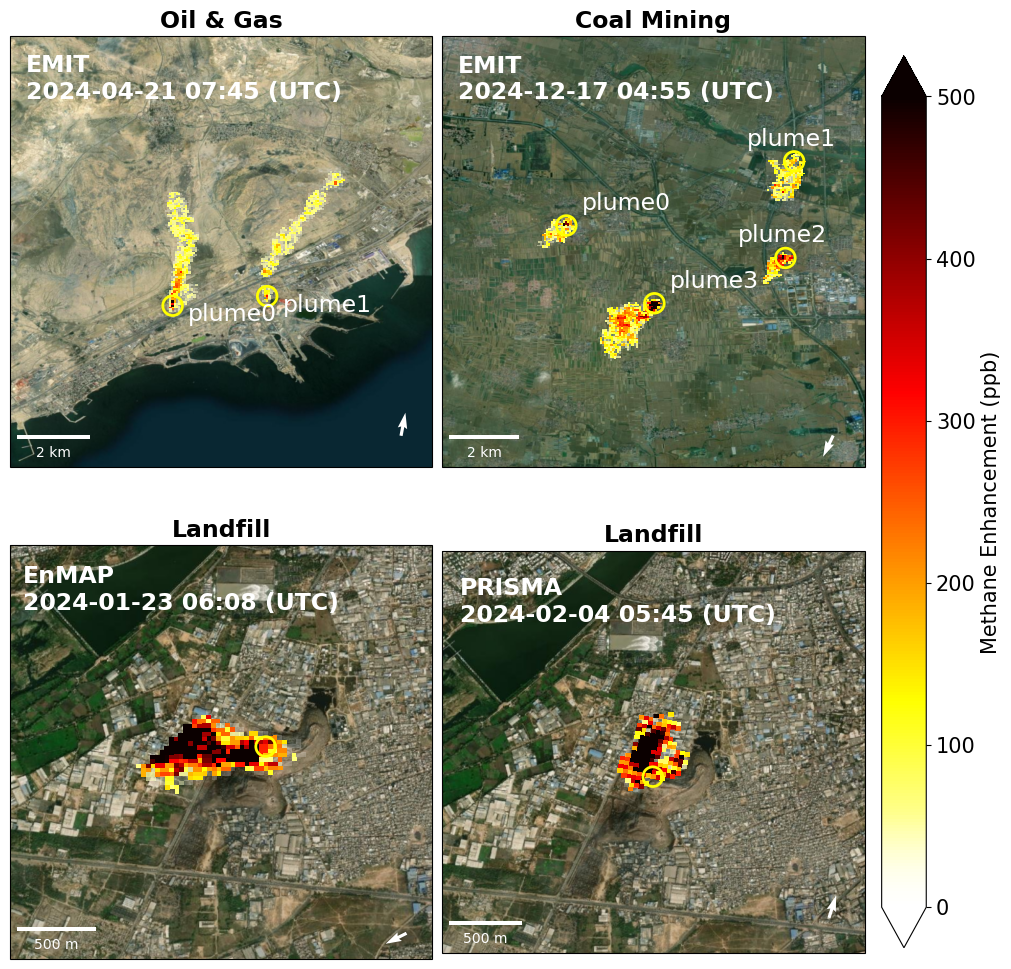

In [10]:
proj = ccrs.PlateCarree()

fig, axs = plt.subplots(nrows=2, ncols=2,
                        subplot_kw={'projection': proj},
                        figsize=(10, 10),
                        constrained_layout=True
                        )

vmax = 500

# ---- Oil & gas ---- #
# set extent
oil_bounds = df_oils[0]['plume_bounds'].item()
pad = 0.05
lon_min = oil_bounds[0] - pad
lon_max = oil_bounds[2] + pad*1.5
lat_min = oil_bounds[1] - pad
lat_max = oil_bounds[3] + pad

ax = axs[0, 0]
ax.set_extent((lon_min, lon_max, lat_min, lat_max), crs=proj)

for index, ds in enumerate(ds_oils):
    m = ds['ch4'].plot(ax=ax, x='longitude', y='latitude', vmin=0, vmax=vmax, cmap=my_cmap, add_colorbar=False, rasterized=True)
    ax.scatter(df_oils[index]['plume_longitude'], df_oils[index]['plume_latitude'], transform=proj, color='yellow',
               linewidth=2, marker='o', fc='none', s=200)
    ax.text(df_oils[index]['plume_longitude']+pad*0.1, df_oils[index]['plume_latitude']-pad*0.1, 'plume'+str(index), transform=proj, c='w', fontsize=17)
ax.set_title('Oil & Gas')
add_scalebar(ax, lon_min, lat_min)
add_time(df_oils[0], ax, lon_min+pad*0.1, lat_max-pad*0.4, proj)
add_wind(df_oils[0], ax, lon_max-pad*0.2, lat_min+pad*0.2, pad, proj)

# ---- Coal mining ---- #
# set extent
coal_bounds = df_coals[3]['plume_bounds'].item()
pad = 0.05
lon_min = coal_bounds[0] - pad
lon_max = coal_bounds[2] + pad*1.3
lat_min = coal_bounds[1] - pad*0.68
lat_max = coal_bounds[3] + pad*1.68

ax = axs[0, 1]
ax.set_extent((lon_min, lon_max, lat_min, lat_max), crs=proj)

for index, ds in enumerate(ds_coals):
    m = ds['ch4'].plot(ax=ax, x='longitude', y='latitude', vmin=0, vmax=vmax, cmap=my_cmap, add_colorbar=False, rasterized=True)
    ax.scatter(df_coals[index]['plume_longitude'], df_coals[index]['plume_latitude'], transform=proj, color='yellow',
               linewidth=2, marker='o', fc='none', s=200)
    if index in [1, 2]:
        ax.text(df_coals[index]['plume_longitude']-pad*0.3, df_coals[index]['plume_latitude']+pad*0.1, 'plume'+str(index), transform=proj, c='w', fontsize=17)
    else:
        ax.text(df_coals[index]['plume_longitude']+pad*0.1, df_coals[index]['plume_latitude']+pad*0.1, 'plume'+str(index), transform=proj, c='w', fontsize=17)

ax.set_title('Coal Mining')
add_scalebar(ax, lon_min, lat_min)
add_time(df_coals[0], ax, lon_min+pad*0.1, lat_max-pad*0.4, proj)
add_wind(df_coals[0], ax, lon_max-pad*0.2, lat_min+pad*0.2, pad, proj)

# ---- landfill enmap ----
ax = axs[1, 0]
ds_landfill_enmap['ch4'].plot(ax=ax, x='longitude', y='latitude', vmin=0, vmax=vmax, cmap=my_cmap, add_colorbar=False, rasterized=True)
ax.scatter(df_landfill_enmap['plume_longitude'], df_landfill_enmap['plume_latitude'], transform=proj, color='yellow',
           linewidth=2, marker='o', fc='none', s=200)
ax.set_title('Landfill')

# set extent
landfill_bounds = df_landfill_enmap['plume_bounds'].item()
pad = 0.008
lon_min = landfill_bounds[0] - pad
lon_max = landfill_bounds[2] + pad
lat_min = landfill_bounds[1] - pad*1.3
lat_max = landfill_bounds[3] + pad*1.3
ax.set_extent((lon_min, lon_max, lat_min, lat_max), crs=proj)
add_scalebar(ax, lon_min, lat_min)
add_time(df_landfill_enmap, ax, lon_min+pad*0.1, lat_max-pad*0.5, proj)
add_wind(df_landfill_enmap, ax, lon_max-pad*0.2, lat_min+pad*0.2, pad, proj)


# ---- landfill prisma ----
ax = axs[1, 1]
m = ds_landfill_prisma['ch4'].plot(ax=ax, x='longitude', y='latitude', vmin=0, vmax=vmax, cmap=my_cmap, add_colorbar=False, rasterized=True)
ax.scatter(df_landfill_prisma['plume_longitude'], df_landfill_prisma['plume_latitude'], transform=proj, color='yellow',
           linewidth=2, marker='o', fc='none', s=200)
ax.set_title('Landfill')

# set extent
landfill_bounds = df_landfill_prisma['plume_bounds'].item()
pad = 0.012
lon_min = landfill_bounds[0] - pad
lon_max = landfill_bounds[2] + pad
lat_min = landfill_bounds[1] - pad*0.92
lat_max = landfill_bounds[3] + pad*0.92
ax.set_extent((lon_min, lon_max, lat_min, lat_max), crs=proj)

add_scalebar(ax, lon_min, lat_min)
add_time(df_landfill_prisma, ax, lon_min+pad*0.1, lat_max-pad*0.4, proj)
add_wind(df_landfill_prisma, ax, lon_max-pad*0.2, lat_min+pad*0.2, pad, proj)

for ax in axs.flatten():
    cx.add_basemap(ax, crs=proj, source=cx.providers.Esri.WorldImagery)
    # remove attributions
    ax.texts[-1].remove()


# add colorbar
fig.colorbar(m, ax=axs, label='Methane Enhancement (ppb)', extend='both', pad=0.02, shrink=0.9)
fig.savefig('../figures/methane_emiss_cases.pdf', bbox_inches='tight')

## Quantification summary

In [14]:
df_merge = pd.concat(list(itertools.chain.from_iterable([df_oils, df_coals, [df_landfill_enmap], [df_landfill_prisma]])))

In [15]:
# df_merge['xname'] = df_merge['name'].replace('solid waste', 'Landfill').str.title()+'\n(' + df_merge['platform'] + ')'

df_merge['xname'] = df_merge['name'].str.title()+'\n'+df_merge['plume_id'].str[-6:]

df_merge["xname"] = df_merge["xname"].where(~df_merge["platform"].eq("EnMAP"), 'Landfill\n(EnMAP)')
df_merge["xname"] = df_merge["xname"].where(~df_merge["platform"].eq("PRISMA"), 'Landfill\n(PRISMA)')

df_merge['emission'] /= 1e3
df_merge['emission_csf'] /= 1e3
df_merge['emission_uncertainty'] /= 1e3
df_merge['emission_csf_uncertainty'] /= 1e3

# df_merge[df_merge['platform'] == 'EnMAP']['xname'] = 'Landfill\n(EnMAP)'
# df_merge[df_merge['platform'] == 'PRISMA']['xname'] = 'Landfill\n(PRISMA)'

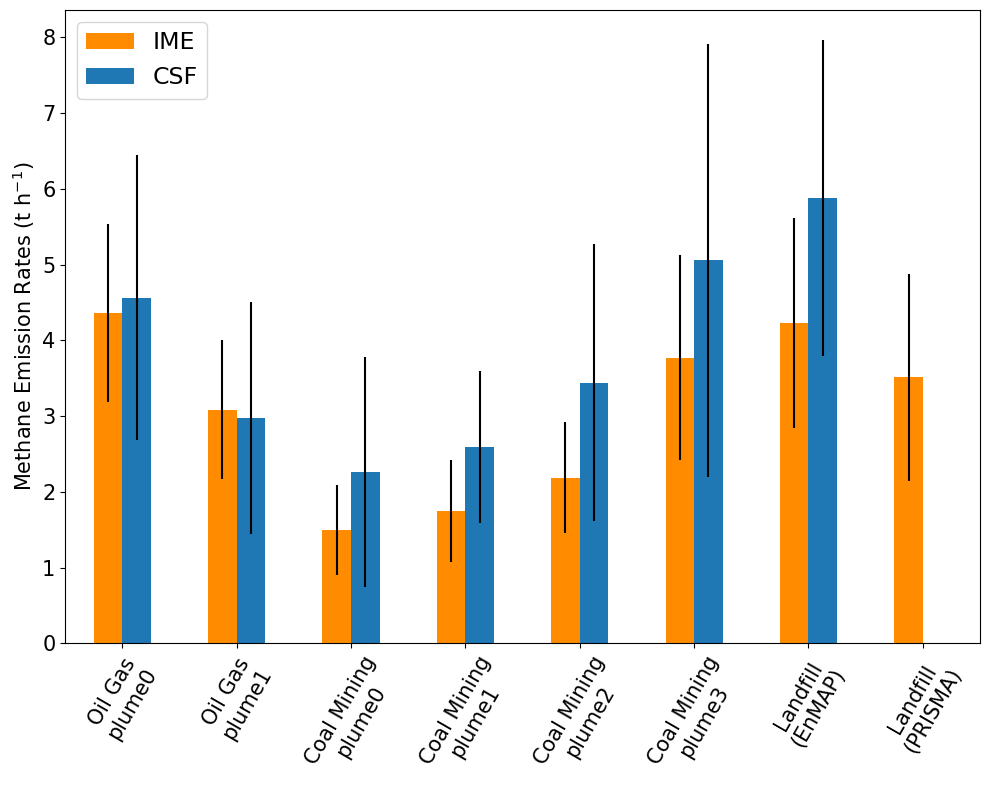

In [18]:
fig, axs = plt.subplots(figsize=(10, 8))

df_merge.rename(columns={'emission': 'IME', 'emission_csf': 'CSF'})\
        .plot(x='xname', y=['IME', 'CSF'],
              ax=axs, rot=60, kind="bar",
              yerr=[df_merge['emission_uncertainty'], df_merge['emission_csf_uncertainty']],
              color=['darkorange', 'C0'],
             )
plt.legend(loc='upper left')

axs.set_ylabel('Methane Emission Rates (t h$^{-1}$)')
axs.set_xlabel('')

fig.tight_layout()
fig.savefig('../figures/methane_emiss_cases_estimate.pdf', bbox_inches='tight')